In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [62]:
## Carregando os dados originais
df = pd.read_excel('Dados_originais/dados_originais.xlsx')

In [63]:
## Espaço atual disponível para armazenamento em m³
espaco_disponivel = 20 * 20 * 2
espaco_disponivel = espaco_disponivel * 0.7 # Calculamos que apenas 70% é de fato aproveitado
## Potencial de vendas médio
indicado_potencial_de_vendas = 1.8
## Meta de vendas mensal
meta_de_vendas = 17_000_000

In [64]:
## Mantendo apenas as colunas necessárias
df = df[['produto.codigo',
         'produto.descricao',
         'produto.precoCusto',
         'produto.marca',
         'produto.grupoProduto',
         'produto.pesoBruto',
         'produto.estoqueMinimo',
         'produto.estoqueMaximo',
         'produto.larguraProduto',
         'produto.alturaProduto',
         'produto.profundidadeProduto',
         'produto.estoqueAtual']].copy()

## Renomenado as colunas para melhor uso no POWER BI
df = df.rename(columns={'produto.codigo': 'codigo',
                        'produto.descricao': 'descricao',
                        'produto.precoCusto': 'preco_custo',
                        'produto.marca': 'marca',
                        'produto.grupoProduto': 'categoria',
                        'produto.pesoBruto': 'peso_bruto_kg',
                        'produto.estoqueMinimo': 'estoque_minimo',
                        'produto.estoqueMaximo': 'estoque_maximo',
                        'produto.larguraProduto': 'largura_cm',
                        'produto.alturaProduto': 'altura_cm',
                        'produto.profundidadeProduto': 'profundidade_cm',
                        'produto.estoqueAtual': 'estoque_atual'})

In [65]:
## Calculando o valor total de estoque por produto
df['preco_custo'] = df['preco_custo'].round(2)
df['custo_total'] = df['estoque_atual'] * df['preco_custo']
## Incluindo o indicador potencial de vendas, vou precisar desse valor no POWER BI
df['indicador_potencial'] = indicado_potencial_de_vendas
## Incluindo a meta de vendas mensal
df['meta_de_vendas'] = meta_de_vendas

In [66]:
# NOVAS COLUNAS PARA SITUAÇÃO DE ESTOQUE

## Substituindo valores negativos por 0
df['estoque_atual'] = df['estoque_atual'].clip(lower=0)
## Nova coluna para mapear a situação do estoque
df['nivel_estoque'] = ''
## 1-Condição de estoque zerado
df.loc[df['estoque_atual'] == 0, 'nivel_estoque'] = 'ZERADO'
## 2-Condição de estoque abaixo do ideal
df.loc[(df['estoque_atual'] < df['estoque_minimo']) &
       (df['estoque_atual'] != 0), 'nivel_estoque'] = 'ABAIXO'
## 3-Condição de estoque acima do ideal
df.loc[df['estoque_atual'] > df['estoque_maximo'], 'nivel_estoque'] = 'ACIMA'
## 4-Condição de estoque ideal
df.loc[(df['estoque_atual'] >= df['estoque_minimo']) &
       (df['estoque_atual'] <= df['estoque_maximo']) &
       (df['estoque_atual'] != 0), 'nivel_estoque'] = 'IDEAL'

In [67]:
# COLUNAS PARA CALCULO DO ESPAÇO DISPONÍVEL E OCUPADO

## Calculando o volume unitário de cada produto em cm³
df['volume_cm3'] = df['altura_cm'] * df['largura_cm'] * df['profundidade_cm']
## Excluindo as linhas onde o volume é igual a zero
df = df.loc[df['volume_cm3'] != 0]
## Calculando o volume total ocupado por cada produto em metros cúbicos (1 m³ = 1.000.000 cm³)
volume_total_ocupado_m3 = (df['volume_cm3'] * df['estoque_atual']) / 1_000_000
## Criando colunas percentuais do espaço total e ocupado
df['espaco_disponivel'] = espaco_disponivel / espaco_disponivel
df['espaco_ocupado'] = volume_total_ocupado_m3 / espaco_disponivel

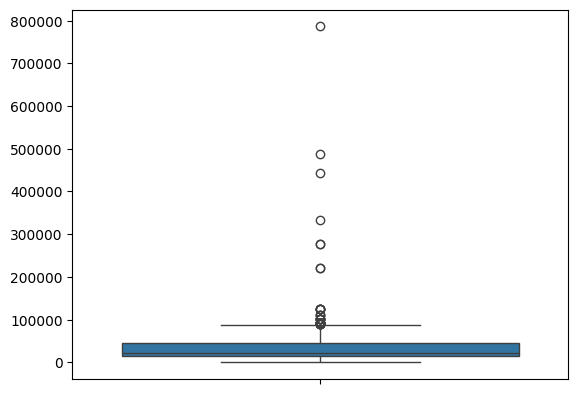

In [68]:
## Calculando o custo por m³ por produto
valor_por_metro_cubico = df['preco_custo'] / (df['volume_cm3'] / 1_000_000)
## Verificando a distribuição dos dados
sns.boxplot(valor_por_metro_cubico)
plt.show()

In [69]:
## Calculando a mediana do custo por m³
mediana_m3 = valor_por_metro_cubico.median() # Foi escolhida a mediana por haver muitos outliers
## Nova coluna com o potencial de vendas do espaço total disponível
df['potencial_do_espaco_disponivel'] = espaco_disponivel * mediana_m3 * indicado_potencial_de_vendas
df['potencial_do_espaco_disponivel'] = df['potencial_do_espaco_disponivel'].round(2)
## Somando o volume total para obter a metragem cúbica total ocupada pelos produtos
espaco_ocupado = round(volume_total_ocupado_m3.sum())
## Nova coluna com o potencial de vendas do espaço atualmente ocupado
df['potencial_do_espaco_ocupado'] =  espaco_ocupado * mediana_m3 * indicado_potencial_de_vendas
df['potencial_do_espaco_ocupado'] = df['potencial_do_espaco_ocupado'].round(2)

In [70]:
## Salvando os dados em Excel
df.to_excel('Dados_limpos/dados_limpos.xlsx', index=False)